In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

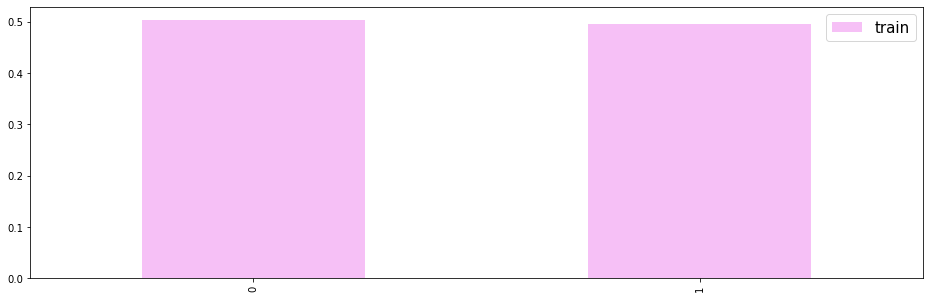

In [3]:
train['sentiment'].value_counts(1).sort_index().plot(
    kind='bar', figsize=(16, 5), color='violet', alpha=0.5, label='train'
);
plt.legend(fontsize=15);

# Предобработка текста

In [6]:
import re
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from tqdm.notebook import tqdm

In [7]:
#Лемматизация
morph = MorphAnalyzer()
test_lemmatized_descriptions = []
for i, description in tqdm(enumerate(test['review'].values), total=len(test)):
    try:
        lemmatized_description = [
            morph.parse(token)[0].normal_form for token in 
            re.findall(r'\w+', description)
        ]
        test_lemmatized_descriptions.append(lemmatized_description)
    except Exception as e:
        print(f'Не удалось распарсить description с индексом={i}:')
        print("descrition:")
        print(description, end='\n\n')
        print(e, end='\n\n')
        test_lemmatized_descriptions.append([])
    
test['lemmatized_descriptions'] = test_lemmatized_descriptions
try:
    json.dump(
        test_lemmatized_descriptions, 
        open('C:/Users/123/Desktop/avito_train_lemmatized_210k.json', mode='w', encoding='utf-8'), 
        ensure_ascii=False, 
        indent=2
    )
except Exception as e:
    print("Не удалось сохранить в C:/Users/123/Desktop/avito_train_lemmatized_210k.json")
    print(e, end='\n\n')

  0%|          | 0/12500 [00:00<?, ?it/s]

Не удалось сохранить в C:/Users/123/Desktop/avito_train_lemmatized_210k.json
name 'json' is not defined



In [10]:
# Делаем просто текст из лемматизированного списка

xs = test.lemmatized_descriptions[1]
s = ' '.join(xs)

test['text']=0


for i in range(len(test.lemmatized_descriptions)):
    test['text'][i]=' '.join(test.lemmatized_descriptions[i])

<ipython-input-10-d69e8facee95>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text'][i]=' '.join(test.lemmatized_descriptions[i])
C:\Users\123\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
test

,id,review,lemmatized_descriptions,text
0,d7593a4a9f7bade74d17667e488a6f3e,"I read that \There's a Girl in My Soup\"" came ...","[i, read, that, there, s, a, girl, in, my, sou...",i read that there s a girl in my soup came out...
1,2294e3b907d750dcc32c35be503da86a,This film pulls you in from the get-go because...,"[this, film, pulls, you, in, from, the, get, g...",this film pulls you in from the get go because...
2,43acdaff0a72ab9a365104db9b163f2e,From the awful death scenes to guns that fire ...,"[from, the, awful, death, scenes, to, guns, th...",from the awful death scenes to guns that fire ...
3,0b061ac5f9c62e45fe922ee28819b73b,I saw that movie few days ago. This movie is s...,"[i, saw, that, movie, few, days, ago, this, mo...",i saw that movie few days ago this movie is so...
4,a80165e5617c4a46a019c4424637f68e,For a film with so much promise it was disappo...,"[for, a, film, with, so, much, promise, it, wa...",for a film with so much promise it was disappo...
...,...,...,...,...
12495,d6ac5f249c1a13a97342220418ade439,"God, I was bored out of my head as I watched t...","[god, i, was, bored, out, of, my, head, as, i,...",god i was bored out of my head as i watched th...
12496,61463dea9e55fd50b8a66fea98d91a03,"This typical Mamet film delivers a quiet, even...","[this, typical, mamet, film, delivers, a, quie...",this typical mamet film delivers a quiet evenl...
12497,bd7627d4598394d0e3f4ec740425ca0a,What a good film! Made Men is a great action m...,"[what, a, good, film, made, men, is, a, great,...",what a good film made men is a great action mo...
12498,f10bf1a9318064af1229d0717ffba33c,"\The Secretary\"" is one of those cheesy, clich...","[the, secretary, is, one, of, those, cheesy, c...",the secretary is one of those cheesy cliched t...


# Модель

### Использую модельку с hugging face (вроде, так можно было) https://huggingface.co/lvwerra/distilbert-imdb?text=I+like+you.+I+love+you, гениальности здесь нет(

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [13]:
MODEL = f"lvwerra/distilbert-imdb"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [14]:
def polarity_scores_imdb(example):
    encoded_text = tokenizer(example, max_length = 511, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'imdb_neg' : scores[0],
        'imdb_pos' : scores[1]
    }
    return scores_dict

In [15]:
res_imdb = {}
for i, row in tqdm(test.iterrows(), total=test.shape[0]):
    try:
        text = row['text']
        myid = row['id']
        imdb_result = polarity_scores_imdb(text)
        res_imdb[myid] = imdb_result
    except RuntimeError:
        print(f'Broke for id {myid}')
        res_imdb[myid] = {
        'imdb_neg' : 0.5,
        'imdb_pos' : 0.5
        }

  0%|          | 0/12500 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
imdb_df = pd.DataFrame(res_imdb).T
imdb_df = imdb_df.reset_index().rename(columns={'index': 'id'})
imdb_df = imdb_df.merge(test, how='inner')

In [17]:
imdb_df

,id,imdb_neg,imdb_pos,review,lemmatized_descriptions,text
0,d7593a4a9f7bade74d17667e488a6f3e,0.994426,0.005574,"I read that \There's a Girl in My Soup\"" came ...","[i, read, that, there, s, a, girl, in, my, sou...",i read that there s a girl in my soup came out...
1,2294e3b907d750dcc32c35be503da86a,0.057634,0.942366,This film pulls you in from the get-go because...,"[this, film, pulls, you, in, from, the, get, g...",this film pulls you in from the get go because...
2,43acdaff0a72ab9a365104db9b163f2e,0.992838,0.007162,From the awful death scenes to guns that fire ...,"[from, the, awful, death, scenes, to, guns, th...",from the awful death scenes to guns that fire ...
3,0b061ac5f9c62e45fe922ee28819b73b,0.007275,0.992725,I saw that movie few days ago. This movie is s...,"[i, saw, that, movie, few, days, ago, this, mo...",i saw that movie few days ago this movie is so...
4,a80165e5617c4a46a019c4424637f68e,0.996396,0.003604,For a film with so much promise it was disappo...,"[for, a, film, with, so, much, promise, it, wa...",for a film with so much promise it was disappo...
...,...,...,...,...,...,...
12495,d6ac5f249c1a13a97342220418ade439,0.993368,0.006632,"God, I was bored out of my head as I watched t...","[god, i, was, bored, out, of, my, head, as, i,...",god i was bored out of my head as i watched th...
12496,61463dea9e55fd50b8a66fea98d91a03,0.004941,0.995059,"This typical Mamet film delivers a quiet, even...","[this, typical, mamet, film, delivers, a, quie...",this typical mamet film delivers a quiet evenl...
12497,bd7627d4598394d0e3f4ec740425ca0a,0.006521,0.993479,What a good film! Made Men is a great action m...,"[what, a, good, film, made, men, is, a, great,...",what a good film made men is a great action mo...
12498,f10bf1a9318064af1229d0717ffba33c,0.945801,0.054199,"\The Secretary\"" is one of those cheesy, clich...","[the, secretary, is, one, of, those, cheesy, c...",the secretary is one of those cheesy cliched t...


In [ ]:
submission = pd.DataFrame()
submission["id"] = imdb_df["id"]
submission["review"] = imdb_df['imdb_pos']

submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)